# M5 Forecasting - Data Preparation and EDA

**Files:**

- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.
- `sales_train_evaluation.csv` - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import dateutil.relativedelta

import os, sys, gc, time, warnings, pickle, psutil, random
from math import ceil
from tqdm import tqdm

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler, PowerTransformer, FunctionTransformer

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

## 1. Data Preparation

In [2]:
## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [3]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Calendar Data

In [4]:
# Calendar data
calendar = pd.read_csv("calendar.csv")
print(f"Shape of the calendar data is: {calendar.shape}")
calendar.head(5)

Shape of the calendar data is: (1969, 14)


date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [5]:
calendar.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [6]:
calendar.isna().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [7]:
print(f"Unique Values in 'event_name_1' column: {calendar['event_name_1'].unique()}")
print(f"\nUnique Values in 'event_type_1' column: {calendar['event_type_1'].unique()}")
print(f"\nUnique Values in 'event_name_2' column: {calendar['event_name_2'].unique()}")
print(f"\nUnique Values in 'event_type_2' column: {calendar['event_type_2'].unique()}")

Unique Values in 'event_name_1' column: [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']

Unique Values in 'event_type_1' column: [nan 'Sporting' 'Cultural' 'National' 'Religious']

Unique Values in 'event_name_2' column: [nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]

Unique Values in 'event_type_2' column: [nan 'Cultural' 'Religious']


In [8]:
print(f"Unique Values in 'snap_CA' column: {calendar['snap_CA'].unique()}")
print(f"Unique Values in 'snap_TX' column: {calendar['snap_TX'].unique()}")
print(f"Unique Values in 'snap_WI' column: {calendar['snap_WI'].unique()}")

Unique Values in 'snap_CA' column: [0 1]
Unique Values in 'snap_TX' column: [0 1]
Unique Values in 'snap_WI' column: [0 1]


In [9]:
# Checking continuity of dates
calendar['date'] = calendar['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
calendar.head(5)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

### Price Data

In [10]:
price = pd.read_csv("sell_prices.csv")
print(f"Shape of the price data is: {price.shape}")
price.head(5)

Shape of the price data is: (6841121, 4)


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [11]:
price = reduce_mem_usage(price)

Mem. usage decreased to 130.48 Mb (37.5% reduction)


### Sales Train Data

In [12]:
train_df = pd.read_csv("sales_train_validation.csv")
print(f"Shape of the sales train data is: {train_df.shape}")
train_df.head(5)

Shape of the sales train data is: (30490, 1919)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [13]:
sample_data_dict = {'dept_id': list(train_df['dept_id'].unique()),
                   'store_id': list(train_df['store_id'].unique())}

In [14]:
def sample_train_data(arg_df, num_sample_per_group=5, arg_seed=42):
    """ Select a sample of `id` from each combination of department and store"""
    
    arg_df = arg_df.sample(frac=1, random_state=arg_seed).reset_index(drop=True)
    temp_df = None
    final_train_df = pd.DataFrame()
    
    for dept in sample_data_dict['dept_id']:
        for store in sample_data_dict['store_id']:
            temp_df = arg_df.loc[((arg_df['dept_id'] == dept) & (arg_df['store_id'] == store)),:].reset_index(drop=True)
            temp_df = temp_df.iloc[:num_sample_per_group,:]
            if (final_train_df.shape == (0,0)):
                final_train_df = temp_df.copy()
            else:
                final_train_df = pd.concat([final_train_df, temp_df], axis=0)
                temp_df = None
    
    final_train_df = final_train_df.reset_index(drop=True)
    
    return(final_train_df)

In [15]:
final_train_df = sample_train_data(train_df, num_sample_per_group=20)
print(f"Shape of the filtered sales train data is: {final_train_df.shape}")
final_train_df.head(5)

Shape of the filtered sales train data is: (1400, 1919)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_287_CA_1_validation  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_100_CA_1_validation  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_258_CA_1_validation  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_217_CA_1_validation  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_225_CA_1_validation  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    1    2    2    1    3    1    5    4    1     2     2     1   
2       CA    0    0    0    0    0    0    0    0    0     0     2     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     1     1     3     3     4     1     3     0     1     1     0     3   
2     3     1     3     0     0     0     0     1     0     2     2     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     3     0     3     1     1     2     2     3     0     4     0     0   
2     1     0     0     3     1     0     0     3     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     2     5     0     0     2     2     1     1     1     1   
2     0     1     0     2     0     2     1     2     1     0     1     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     1     1     2     1     2     1     1     0     3     2     1     3   
2     0     0     0     0     1     0     0     2     1     4     0     2   
3     0     0     0     0     0     0     0     0     0     0     0     1   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     1     2     4     1     1     2     1     0     2     0     1     1   
2     0     0     0     0     1     0     1     0     2     2     4     4   
3     0     0     0     0     0     1     0     0     0     0     0     1   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     1     1     0     0     1     2     2     0     0     0     4     1   
2     1     2     6     1     0     0     0     0     0     1     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     1     1     1     0     0     3     1     2     1     2     3     0   
2     4     1     2     3     0     1     0     1     3     0     0     1   


In [16]:
train_df = final_train_df.copy()
train_df = reduce_mem_usage(train_df)
print(f"Size of the filtered training data is: {train_df.memory_usage().sum() / 1024**2:.2f} Mb")
del final_train_df

Mem. usage decreased to  2.68 Mb (86.9% reduction)
Size of the filtered training data is: 2.68 Mb


In [17]:
val_df = pd.read_csv("sales_train_evaluation.csv")
print(f"Shape of the sales validation data is: {val_df.shape}")
val_df.head(5)

Shape of the sales validation data is: (30490, 1947)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [18]:
selected_product_ids = list(train_df['id'].unique())
selected_product_ids = [sub.replace('validation', 'evaluation') for sub in selected_product_ids]
val_df = val_df.loc[(val_df['id'].isin(selected_product_ids))].reset_index(drop=True)
val_df = reduce_mem_usage(val_df)
print(f"Size of the filtered validation data is: {val_df.memory_usage().sum() / 1024**2:.2f} Mb")
print(f"Shape of the sales validation data is: {val_df.shape}")

Mem. usage decreased to  2.72 Mb (86.9% reduction)
Size of the filtered validation data is: 2.72 Mb
Shape of the sales validation data is: (1400, 1947)


In [19]:
# xx = val_df.copy()
# xx['sum_last_28_days'] = xx.iloc[:,-28:].sum(1)
# print(xx['sum_last_28_days'].min())
# print(xx['sum_last_28_days'].max())
# print(xx['sum_last_28_days'].mean())

In [20]:
# xx.loc[xx['store_id'] == "WI_3",'sum_last_28_days'].hist(bins=10, figsize=(10,5))

In [21]:
# sample_data_dict

#### Transforming Sales Data from Wide to Tall Format

In [22]:
sales_cols = list(train_df.columns)
sales_id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_value_cols = list(np.setdiff1d(sales_cols,sales_id_cols))

sales_cols_2 = list(val_df.columns)
sales_value_cols_2 = list(np.setdiff1d(sales_cols_2,sales_id_cols))

train_df_2 = pd.melt(train_df, id_vars=sales_id_cols, value_vars=sales_value_cols)
val_df_2 = pd.melt(val_df, id_vars=sales_id_cols, value_vars=sales_value_cols_2)

train_df_2 = train_df_2.drop(['id'], axis=1)
val_df_2 = val_df_2.drop(['id'], axis=1)

del train_df, val_df

In [23]:
train_df_2.head(5)

item_id    dept_id   cat_id store_id state_id variable  value
0  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA      d_1      0
1  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA      d_1      1
2  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA      d_1      0
3  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1       CA      d_1      0
4  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1       CA      d_1      0

#### Joining Sales and Calendar Data

In [24]:
train_df_2 = pd.merge(train_df_2, calendar, left_on="variable", right_on="d", how="left")
val_df_2 = pd.merge(val_df_2, calendar, left_on="variable", right_on="d", how="left")

train_df_2 = train_df_2.drop(['variable', 'd'], axis=1)
val_df_2 = val_df_2.drop(['variable', 'd'], axis=1)

train_df_2.head(5)

item_id    dept_id   cat_id store_id state_id  value       date  \
0  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
1  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA      1 2011-01-29   
2  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
3  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
4  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   

   wm_yr_wk   weekday  wday  month  year event_name_1 event_type_1  \
0     11101  Saturday     1      1  2011          NaN          NaN   
1     11101  Saturday     1      1  2011          NaN          NaN   
2     11101  Saturday     1      1  2011          NaN          NaN   
3     11101  Saturday     1      1  2011          NaN          NaN   
4     11101  Saturday     1      1  2011          NaN          NaN   

  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN        0        0        0  
1          NaN          NaN        0        0        0  
2          NaN          NaN        0        0        0  
3          NaN          NaN        0        0        0  
4          NaN          NaN        0        0        0

#### Joining Sales and Price Data

In [25]:
train_df_2 = pd.merge(train_df_2, price, on=['wm_yr_wk', 'store_id', 'item_id'], how="left")
val_df_2 = pd.merge(val_df_2, price, on=['wm_yr_wk', 'store_id', 'item_id'], how="left")

train_df_2 = train_df_2.drop(['wm_yr_wk', 'wday'], axis=1)
val_df_2 = val_df_2.drop(['wm_yr_wk', 'wday'], axis=1)

train_df_2.head(5)

item_id    dept_id   cat_id store_id state_id  value       date  \
0  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
1  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA      1 2011-01-29   
2  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
3  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   
4  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1       CA      0 2011-01-29   

    weekday  month  year event_name_1 event_type_1 event_name_2 event_type_2  \
0  Saturday      1  2011          NaN          NaN          NaN          NaN   
1  Saturday      1  2011          NaN          NaN          NaN          NaN   
2  Saturday      1  2011          NaN          NaN          NaN          NaN   
3  Saturday      1  2011          NaN          NaN          NaN          NaN   
4  Saturday      1  2011          NaN          NaN          NaN          NaN   

   snap_CA  snap_TX  snap_WI  sell_price  
0        0        0        0         NaN  
1        0        0        0        10.0  
2        0        0        0         NaN  
3        0        0        0         NaN  
4        0        0        0         NaN

In [26]:
# Cleaning column names
train_df_2.rename(columns={'value':'sales'}, inplace=True)
val_df_2.rename(columns={'value':'sales'}, inplace=True)

arrange_cols = ['date', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
               'weekday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
                'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sales']

train_df_2 = train_df_2[arrange_cols]
val_df_2 = val_df_2[arrange_cols]

train_df_2 = reduce_mem_usage(train_df_2)
val_df_2 = reduce_mem_usage(val_df_2)

del price, calendar

train_df_2.head(3)

Mem. usage decreased to 270.74 Mb (24.3% reduction)
Mem. usage decreased to 274.70 Mb (24.3% reduction)


date        item_id    dept_id   cat_id store_id state_id   weekday  \
0 2011-01-29  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
1 2011-01-29  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
2 2011-01-29  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   

   month  year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0      1  2011          NaN          NaN          NaN          NaN        0   
1      1  2011          NaN          NaN          NaN          NaN        0   
2      1  2011          NaN          NaN          NaN          NaN        0   

   snap_TX  snap_WI  sell_price  sales  
0        0        0         NaN      0  
1        0        0        10.0      1  
2        0        0         NaN      0

In [27]:
train_df_2.dtypes

date            datetime64[ns]
item_id                 object
dept_id                 object
cat_id                  object
store_id                object
state_id                object
weekday                 object
month                     int8
year                     int16
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_CA                   int8
snap_TX                   int8
snap_WI                   int8
sell_price             float16
sales                    int16
dtype: object

In [28]:
train_df_2.shape

(2678200, 18)

In [29]:
val_df_2.shape

(2717400, 18)

In [30]:
val_df_2.isna().sum()

date                  0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
weekday               0
month                 0
year                  0
event_name_1    2496200
event_type_1    2496200
event_name_2    2711800
event_type_2    2711800
snap_CA               0
snap_TX               0
snap_WI               0
sell_price       577276
sales                 0
dtype: int64

In [31]:
# Check if sum of sales when price is missing
print(train_df_2.loc[(pd.isna(train_df_2['sell_price'])==True), 'sales'].sum())
print(val_df_2.loc[(pd.isna(val_df_2['sell_price'])==True), 'sales'].sum())

0
0


## 2. Exploratory Data Analysis and Visualization

In [32]:
def plot_time_series(arg_df, plot_col="sales", arg_item_id=None, arg_store_id=None, st_dt=None, arg_window=None, end_dt=None):
    """ """
        
    st_dt = datetime.strptime(st_dt, '%Y-%m-%d')
    select_df = arg_df[((arg_df['item_id'] == arg_item_id) & (arg_df['store_id'] == arg_store_id))].reset_index()
    
    if(arg_window != None):
        end_dt = st_dt + timedelta(days=arg_window)
    else:
        end_dt = datetime.strptime(end_dt, '%Y-%m-%d')
    
    select_df = select_df[((select_df['date'] >= st_dt) & (select_df['date'] <= end_dt))].reset_index(drop=True)
        
    plt.figure(figsize=(20, 6))
    sns.lineplot(y=select_df[plot_col], x=select_df['date'], marker='o')
    plt.xlabel("Date")
    plt.ylabel(f"{plot_col}")
    plt.title(f"{plot_col} vs. Time")

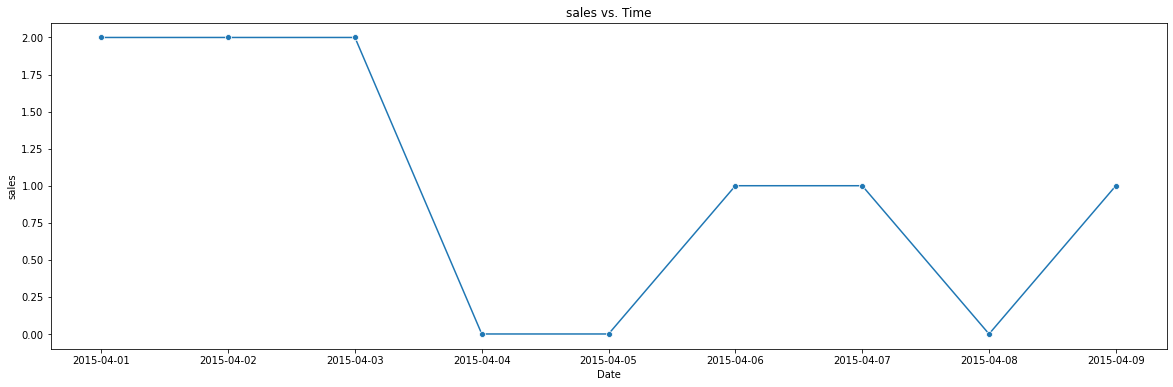

In [33]:
plot_time_series(arg_df=train_df_2,
                 plot_col='sales',
                 arg_item_id='HOBBIES_1_287',
                 arg_store_id='CA_1',
                 st_dt='2015-04-01',
                 arg_window=8)

### Feature Engineering

In [34]:
train_df_2.head(5)

date        item_id    dept_id   cat_id store_id state_id   weekday  \
0 2011-01-29  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
1 2011-01-29  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
2 2011-01-29  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
3 2011-01-29  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
4 2011-01-29  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   

   month  year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0      1  2011          NaN          NaN          NaN          NaN        0   
1      1  2011          NaN          NaN          NaN          NaN        0   
2      1  2011          NaN          NaN          NaN          NaN        0   
3      1  2011          NaN          NaN          NaN          NaN        0   
4      1  2011          NaN          NaN          NaN          NaN        0   

   snap_TX  snap_WI  sell_price  sales  
0        0        0         NaN      0  
1        0        0        10.0      1  
2        0        0         NaN      0  
3        0        0         NaN      0  
4        0        0         NaN      0

In [35]:
def binary_encode(arg_df, arg_cols, fit=True, bin_enc=None):
    """Function to perform binary encoding"""
    
    #Create object for binary encoding
    encoder = ce.BinaryEncoder(cols=arg_cols,return_df=True)

    #Fit and Transform Data 
    arg_df_subset = pd.DataFrame(arg_df[arg_cols], columns=arg_cols)
    if(fit == True):
        arg_df_subset = encoder.fit_transform(arg_df_subset)
    else:
        arg_df_subset = bin_enc.transform(arg_df_subset)
        encoder = bin_enc
    
#     arg_df_subset = pd.DataFrame(arg_df_subset, columns=arg_cols)
    arg_df = arg_df.drop(arg_cols, axis=1)
    arg_df = pd.concat([arg_df, arg_df_subset], axis=1)

    return(arg_df, encoder)

In [36]:
def ohe_encode(arg_df, arg_cols, drop_first=False, fit=True, ohe=None):
    """Function to perform one-hot encoding"""
    
    #Create object for One Hot Encoding
    if(drop_first == True):
        one_hot_enc = OneHotEncoder(drop='first')
    else:
        one_hot_enc = OneHotEncoder()

    #Fit and Transform Data 
    arg_df_subset = pd.DataFrame(arg_df[arg_cols], columns=arg_cols)
    if(fit == True):
        arg_df_subset = one_hot_enc.fit_transform(arg_df_subset).toarray()
        arg_df_subset = pd.DataFrame(arg_df_subset, columns=one_hot_enc.get_feature_names(arg_cols))
    else:
        arg_df_subset = ohe.transform(arg_df_subset).toarray()
        arg_df_subset = pd.DataFrame(arg_df_subset, columns=ohe.get_feature_names(arg_cols))
        one_hot_enc = ohe

    arg_df = arg_df.drop(arg_cols, axis=1)
    arg_df = pd.concat([arg_df, arg_df_subset], axis=1)
    
    return(arg_df, one_hot_enc)

In [37]:
# Function to perform desired scaling for numeric features

def log_transform(x):
    print(x)
    return np.log(x + 1)

log_transformer = FunctionTransformer(log_transform)

numeric_scaler_dict = {'standard_scaler': StandardScaler(),
                       'max_abs_scaler': MaxAbsScaler(),
                       'min_max_scaler': MinMaxScaler(),
                       'robust_scaler': RobustScaler(),
                       'power_transformer_box_cox': PowerTransformer(method='box-cox'), # only works for strictly positive values
                       'power_transformer_yeo_johnson': PowerTransformer(method='yeo-johnson'),
                       'log_transformation': log_transformer}


def numeric_scaler(arg_df, arg_cols, scaling_technique='standard_scaler', fit=True, num_scaler=None):
    """Function to perform desired scaling of numeric features
       When `fit` = True, the standard scaler will do both fit and transform of the data.
       When `fit` = False, the standard scaler will ONLY transform the data.
      
       Function returns the transformed data and the scaler object."""
    
    #Create object for scaling
    scaler = numeric_scaler_dict[scaling_technique]
    
    arg_df_subset = pd.DataFrame(arg_df[arg_cols], columns=arg_cols)

    #Fit and Transform Data
    if(fit == True):
        arg_df_subset = scaler.fit_transform(arg_df_subset)
    
    if(fit == False):
        arg_df_subset = num_scaler.transform(arg_df_subset)    
    
    arg_df_subset = pd.DataFrame(arg_df_subset, columns=arg_cols)
    arg_df = arg_df.drop(arg_cols, axis=1)
    arg_df = pd.concat([arg_df, arg_df_subset], axis=1)
    
    return(arg_df, scaler)

In [38]:
# def missing_price(arg_df):
#     """Function to treat missing values in `sell_price` column"""
    
#     arg_df.loc[(pd.isna(arg_df['sell_price'])), 'no_sell_flag'] = 1
#     arg_df.loc[~(pd.isna(arg_df['sell_price'])), 'no_sell_flag'] = 0
#     arg_df.loc[(pd.isna(arg_df['sell_price'])), 'sell_price'] = 0

In [39]:
# xx = train_df_2.copy()
# # xx = xx.groupby()[].shift(1, freq=pd.DateOffset(years=2))

# new_column = (xx.set_index('date').groupby(['item_id'])[['sell_price', 'sales']].shift(1, freq=pd.DateOffset(days=2)))
# xx.set_index(['item_id', 'date'], inplace=True)
# # xx['l2_invest'] = new_column
# xx = pd.concat([xx, new_column], axis=1)
# xx.reset_index(inplace=True)
# # df.reset_index(inplace=True)
# xx.head(5)

In [40]:
# new_column.loc[['HOUSEHOLD_2_516'], ['sell_price','sales']]

In [41]:
# xx.loc[['HOUSEHOLD_2_516'], ['sell_price','sales']]

In [42]:
train_df_2.head(5)

date        item_id    dept_id   cat_id store_id state_id   weekday  \
0 2011-01-29  HOBBIES_1_287  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
1 2011-01-29  HOBBIES_1_100  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
2 2011-01-29  HOBBIES_1_258  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
3 2011-01-29  HOBBIES_1_217  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   
4 2011-01-29  HOBBIES_1_225  HOBBIES_1  HOBBIES     CA_1       CA  Saturday   

   month  year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0      1  2011          NaN          NaN          NaN          NaN        0   
1      1  2011          NaN          NaN          NaN          NaN        0   
2      1  2011          NaN          NaN          NaN          NaN        0   
3      1  2011          NaN          NaN          NaN          NaN        0   
4      1  2011          NaN          NaN          NaN          NaN        0   

   snap_TX  snap_WI  sell_price  sales  
0        0        0         NaN      0  
1        0        0        10.0      1  
2        0        0         NaN      0  
3        0        0         NaN      0  
4        0        0         NaN      0

In [55]:
aggregate_dict = {'item_level': ['item_id', 'store_id'],
                  'dept_level': ['dept_id', 'store_id'],
                  'cat_level': ['cat_id', 'store_id'],
                  'store_level': ['store_id']}

def shift_periods(arg_df, arg_cols, arg_level, arg_days, arg_col_name=None):
    """Function to shift the rows by specified periods for selected columns.
        This function can be used to create lag features"""
    
    new_df = (arg_df.set_index('date').groupby(aggregate_dict[arg_level])[arg_cols].shift(1, freq=pd.DateOffset(days=arg_days)))
    if(arg_col_name == None):
        new_colnames = "lag_" + arg_days + "_" + new_df.columns
    else:
        new_colnames = arg_col_name + "_" + new_df.columns
    
    new_df.columns = new_colnames
    new_df.reset_index(inplace=True)
    arg_df = pd.merge(arg_df, new_df, on=aggregate_dict[arg_level] + ['date'], how='left')
    
    return(arg_df)

# xx = shift_periods(arg_df=train_df_2, 
#                    arg_cols=['sell_price', 'sales'], 
#                    arg_level='item_level', 
#                    arg_days=1, 
#                    arg_col_name="P1")

# xx.head(10)

In [ ]:
# def elasticity_calc(arg_df, q1, q2, p1, p2, arg_col_name):
#     """Calculating arc price elasticity"""
    
#     arg_df[arg_col_name] = ((arg_df[q2] - arg_df[q1])/((arg_df[q1] + arg_df[q2])/2)) / ((arg_df[p2] - arg_df[p1])/((arg_df[p1] + arg_df[p2])/2))
    
#     return(arg_df)
    

# def price_elasticity_features(arg_df):
#     """Create price elasticity based features"""
    
#     for level in aggregate_dict.keys:
#         # Weekly elasticity
#         arg_df = shift_periods(arg_df, 
#                                arg_cols=['sell_price', 'sales'], 
#                                arg_level=level, 
#                                arg_days=7, 
#                                arg_col_name="P7_" + level)
        

#         arg_df = shift_periods(arg_df, 
#                                arg_cols=['sell_price', 'sales'], 
#                                arg_level=level, 
#                                arg_days=14, 
#                                arg_col_name="P14_" + level)
        
#         arg_df = elasticity_calc(arg_df, 
#                                  q1="P7_" + level + "_sales", 
#                                  q2="P14_" + level + "_sales", 
#                                  p1="P7_" + level + "_sell_price", 
#                                  p2="P14_" + level + "_sell_price", 
#                                  arg_col_name=level + "_weekly_elasticity")
        
#         arg_df = arg_df.drop(["P7_" + level + "_sales", 
#                               "P14_" + level + "_sales", 
#                               "P7_" + level + "_sell_price", 
#                               "P14_" + level + "_sell_price"], axis=1)
        
#         # Monthly elasticity
#         arg_df = shift_periods(arg_df, 
#                                arg_cols=['sell_price', 'sales'], 
#                                arg_level=level, 
#                                arg_days=30, 
#                                arg_col_name="P30_" + level)
        

#         arg_df = shift_periods(arg_df, 
#                                arg_cols=['sell_price', 'sales'], 
#                                arg_level=level, 
#                                arg_days=60, 
#                                arg_col_name="P60_" + level)
        
#         arg_df = elasticity_calc(arg_df, 
#                                  q1="P30_" + level + "_sales", 
#                                  q2="P60_" + level + "_sales", 
#                                  p1="P30_" + level + "_sell_price", 
#                                  p2="P60_" + level + "_sell_price", 
#                                  arg_col_name=level + "_monthly_elasticity")
        
#         arg_df = arg_df.drop(["P30_" + level + "_sales", 
#                               "P60_" + level + "_sales", 
#                               "P30_" + level + "_sell_price", 
#                               "P60_" + level + "_sell_price"], axis=1)

['item_id', 'store_id']